# Reacher project work report

This notebook provides a walkthrough of the work done for the reacher project. 

In [1]:
# !python -m pip install unityagents
# !python -m pip install torch
# !python -m pip install numpy
# !python -m pip install matplotlib
# !python -m pip install 'prompt-toolkit==1.0.15'
# %pdb

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import DDPGAgent
from reacher import *
%matplotlib inline
import matplotlib.pyplot as plt

# reload automatically imported modules when they are modified
# this allows to avoid kernel restarting every time we
# change the dependencies of this notebook
%load_ext autoreload
%autoreload 2

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='../resources/Reacher_Linux/Reacher.x86_64', worker_id=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain and other environment data
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset environment and get task information
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

## Vanilla DDPG
As a first start we instantiate a vanilla DDPG and try to solve the task

In [5]:
agent = DDPGAgent(state_size, action_size, random_seed=0)

In [6]:
scores, std = train(agent, env, n_episodes=500, score_window_size=100, max_score=30)

/home/ammi/Development/reacher/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ammi/Development/reacher/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 50	Average Score: 1.23
Episode 100	Average Score: 1.75
Episode 150	Average Score: 2.71
Episode 200	Average Score: 4.24
Episode 250	Average Score: 5.40
Episode 300	Average Score: 5.79
Episode 350	Average Score: 6.34
Episode 400	Average Score: 8.59
Episode 450	Average Score: 13.03
Episode 500	Average Score: 18.47


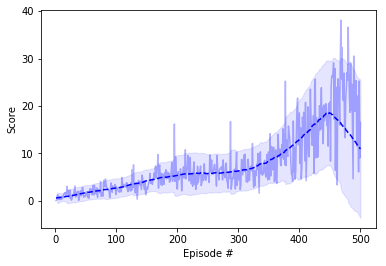

In [49]:
plot_scores(scores, std)

In [8]:
# env_info = env.reset(train_mode=False)[brain_name]
# # load actor and critic weights for demonstration
# states = env_info.vector_observations                  # get the current state
# scores = np.zeros(num_agents)                          # initialize the score
# while True:
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state
#     rewards = env_info.rewards                         # get reward
#     dones = env_info.local_done                        # see if episode finished
    
#     actions = agent.act(states, add_noise=False)       # select an 
#     agent.step(states, actions, rewards, next_states, dones)
    
#     scores += env_info.rewards                         # update the score
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

We close the environment when we are done.

In [9]:
env.close()